In [ ]:
include("ct_utils.jl")
using ChargeTransport
using .CTUtils
using DataFrames
using CSV 
using PyPlot

In [2]:
data_type = ["dark-sc", "illuminated-sc"]
data_choice = 2

generation_filename = "../simulation_data/scaps/si-topcon-auto.gen"

df_ct = ct_to_df("../simulation_data/chargetransport/si-topcon-$(data_type[data_choice]).csv")
df_scaps = scaps_to_df("../simulation_data/scaps/si-topcon-$(data_type[data_choice]).eb")
df_gen = scaps_to_df_generation(generation_filename)
println("Data loaded successfully.")

Data loaded successfully.


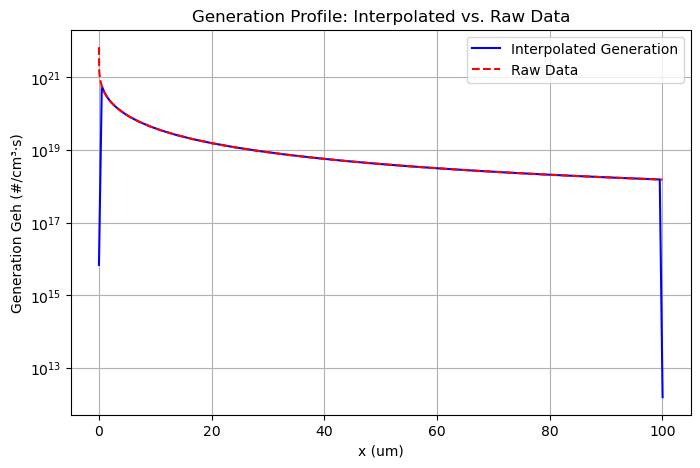

In [14]:
using PyPlot

# Define a range of x values for smooth interpolation
x_vals = range(minimum(df_gen[!, "x (um)"]), stop=maximum(df_gen[!, "x (um)"]), length=200)
G_interp = [generation_from_scaps(generation_filename, x * (μm)) * 1e-6 for x in x_vals]

figure(figsize=(8,5))
plot(x_vals, G_interp, label="Interpolated Generation", color="blue")
plot(df_gen[!, "x (um)"], df_gen[!, "Geh (#/cm3.s)"], linestyle="--", label="Raw Data", color="red")

yscale("log")
xlabel("x (um)")
ylabel("Generation Geh (#/cm³·s)")
title("Generation Profile: Interpolated vs. Raw Data")
legend()
grid(true)
display(gcf())

In [19]:
println("At x = $(x_vals[1]) um, G = $(G_interp[1]) cm-3 s-1")

At x = 0.0 um, G = 6.81972161e15 cm-3 s-1


## COMPARISONS

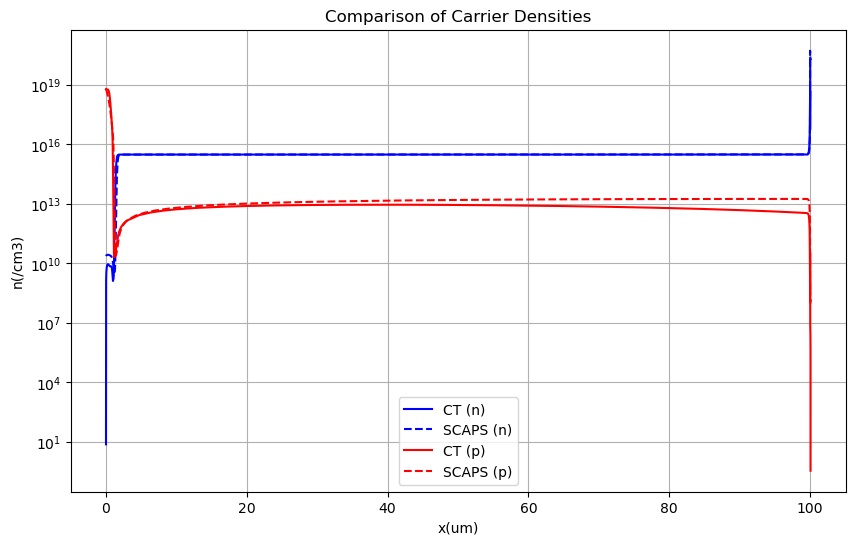

In [3]:
compare_densities(df_ct, df_scaps)
display(gcf())

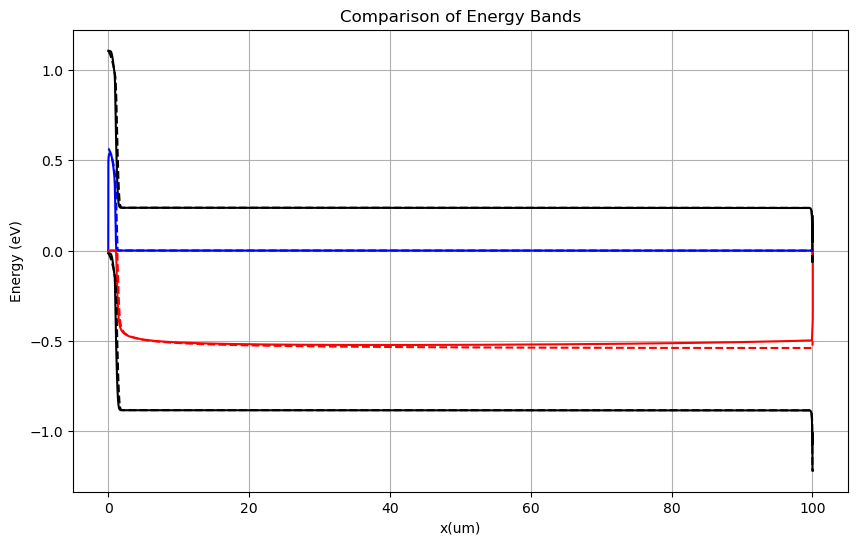

In [5]:
compare_bands(df_ct, df_scaps)
display(gcf())

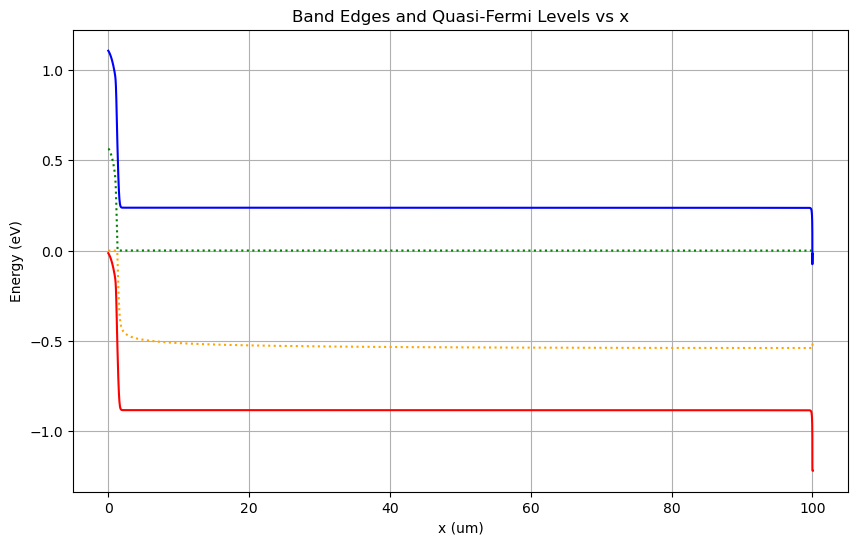

In [6]:
using PyPlot

figure(figsize=(10,6))
plot(df_scaps[!, "x(um)"], df_scaps[!, "Ec(eV)"], color="blue")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Ev(eV)"], color="red")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Fn(eV)"], color="green", linestyle=":")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Fp(eV)"], color="orange", linestyle=":")
xlabel("x (um)")
ylabel("Energy (eV)")
title("Band Edges and Quasi-Fermi Levels vs x")
# legend()
grid(true)
display(gcf())

In [7]:
decay(x) = 6.82e27 * exp(-8.408e4 * x)

decay (generic function with 1 method)

In [8]:
distance = 42.2 * (μm)
decay(distance)

1.9625969384624955e26

In [9]:
using DataFrames

filename = "../simulation_data/scaps/si-topcon-auto.gen"
lines = readlines(filename)
# Find the line containing 'GEN'
gen_idx = findfirst(x -> occursin("GEN", x), lines)
if isnothing(gen_idx) || gen_idx == length(lines)
    error("No GEN line or header found in file.")
end
# The header is the line after 'GEN'
header_idx = gen_idx + 1
header = strip.(split(strip(lines[header_idx]), '\t'))
# Replace Greek mu (μ) with 'u' in header names for easier access
header = replace.(header, 'μ' => "u")
# Data starts after the header
data_start = header_idx + 1
data_lines = filter(x -> !isempty(strip(x)), lines[data_start:end])
# Split each data line into fields using tab delimiter
data = [split(strip(line), '\t') for line in data_lines]
# Convert to numbers if possible
data = [map(x -> tryparse(Float64, x) === nothing ? x : parse(Float64, x), row) for row in data]
df_gen = DataFrame([getindex.(data, i) for i in 1:length(header)], Symbol.(header))

Row,x (um),Geh (#/cm3.s),Total recombination (#/cm3.s),SRH recombination (#/cm3.s),Radiative recombination (#/cm3.s),Auger recombination (#/cm3.s),"net Gn1,1,1 (#/cm3.s)","IPV Gn1,1,1 (#/cm3.s)","Gnth1,1,1 (#/cm3.s)","Rnth1,1,1 (#/cm3.s)","net Gp1,1,1 (#/cm3.s)","IPV Gp1,1,1 (#/cm3.s)","Gpth1,1,1 (#/cm3.s)","Rpth1,1,1 (#/cm3.s)","net Gn2,1,1 (#/cm3.s)","IPV Gn2,1,1 (#/cm3.s)","Gnth2,1,1 (#/cm3.s)","Rnth2,1,1 (#/cm3.s)","net Gp2,1,1 (#/cm3.s)","IPV Gp2,1,1 (#/cm3.s)","Gpth2,1,1 (#/cm3.s)","Rpth2,1,1 (#/cm3.s)"
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,6.81972e21,7.42736e17,2.2929e10,5.80612e14,7.42156e17,-2.2929e10,0.0,34.6232,2.2929e10,-2.2929e10,0.0,6.94936e9,2.98783e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0001,6.76964e21,7.42568e17,2.29342e10,5.80612e14,7.41987e17,-2.29342e10,0.0,34.637,2.29342e10,-2.29342e10,0.0,6.94936e9,2.98835e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000202195,6.71899e21,7.42395e17,2.29394e10,5.80611e14,7.41815e17,-2.29394e10,0.0,34.6512,2.29394e10,-2.29394e10,0.0,6.94936e9,2.98888e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000311015,6.66563e21,7.42211e17,2.2945e10,5.8061e14,7.4163e17,-2.2945e10,0.0,34.6662,2.2945e10,-2.2945e10,0.0,6.94936e9,2.98944e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000431276,6.60736e21,7.42006e17,2.29512e10,5.80608e14,7.41425e17,-2.29512e10,0.0,34.6829,2.29512e10,-2.29512e10,0.0,6.94936e9,2.99006e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000568624,6.54168e21,7.41771e17,2.29582e10,5.80604e14,7.4119e17,-2.29582e10,0.0,34.7018,2.29582e10,-2.29582e10,0.0,6.94936e9,2.99076e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000730061,6.46565e21,7.41493e17,2.29665e10,5.806e14,7.40913e17,-2.29665e10,0.0,34.724,2.29665e10,-2.29665e10,0.0,6.94936e9,2.99158e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000924613,6.37569e21,7.41157e17,2.29763e10,5.80592e14,7.40577e17,-2.29763e10,0.0,34.7508,2.29763e10,-2.29763e10,0.0,6.94936e9,2.99256e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00116423,6.26731e21,7.4074e17,2.29883e10,5.80581e14,7.4016e17,-2.29883e10,0.0,34.7837,2.29883e10,-2.29883e10,0.0,6.94936e9,2.99377e10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
function predict_generation(df::DataFrame, xq::Float64)
    x = df[!, "x (um)"]
    Geh = df[!, "Geh (#/cm3.s)"]

    # Find the interval containing xq
    if xq <= x[1]
        return Geh[1]
    elseif xq >= x[end]
        return Geh[end]
    else
        i = findfirst(i -> x[i] <= xq < x[i+1], 1:length(x)-1)
        println("Interval found: ", i)
        if isnothing(i)
            error("xq is out of bounds or data is not sorted.")
        end
        # Exponential interpolation: Geh(x) = Geh1 * exp(log(Geh2/Geh1) * (xq-x1)/(x2-x1))
        x1, x2 = x[i], x[i+1]
        G1, G2 = Geh[i], Geh[i+1]
        return G1 * exp(log(G2/G1) * (xq - x1) / (x2 - x1))
    end
end

# Example usage:
G_pred = predict_generation(df_gen, 0.5)

Interval found: 34



5.810862755846824e20